In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os, alive_progress
from alive_progress import alive_bar

from utils import VD_A_DF as vdadf
from utils import apfd
from utils import derive_data

# set inline print
%matplotlib inline

# Load CSV, calculate APFD and filter Equivalent==OK

In [2]:
df = pd.concat([pd.read_csv(os.path.join(path_log)) 
                for path_log in ["k_1_k_2_hads_hsi_w_wp_fixed.csv", "k_1_k_2_spy_spyh.csv"]
               ])
df = derive_data(df)

df['CTT'] = df['CTT'].str.replace('Soucha','')
df['CTT'] = pd.Categorical(df['CTT'], ["W", "Wp", "Hsi", "SPY", "SPYH", "HadsInt"])

# count values where Equivalent=='NOK'
with pd.option_context('display.max_rows', 400):
    subset = ['Equivalent','Extra States','CTT']
    display(df[[*subset]].groupby(subset)
            .value_counts()
            .to_frame()
            .pivot_table(0,[subset[0],subset[1]],[subset[2]])
           )

df_equiv=df.query(f'`Equivalent`=="OK" and `Extra States`==2').sort_values(by=['APFDx'],ascending=False)


CTT                       W  Wp  Hsi  SPY  SPYH  HadsInt
Equivalent Extra States                                 
NOK        1              7   6    6    6     8        6
           2              0   0    0    0     0        0
OK         1             39  40   40   40    38       40
           2             46  46   46   46    46       46

# Setup the list of SULs to be analyzed

In [3]:
all_qtype = ['Testing symbols'] # alternative
all_runs = df_equiv[['SUL name', 'Seed']].drop_duplicates()
total = len(all_qtype)*len(all_runs)

# Plot %states detected per test case (for all methods)

In [4]:
# define figure size
sns.set(rc={'figure.figsize':(10,5),'figure.dpi':300})

os.makedirs(f'img/fixed_mode/', exist_ok=True)

with alive_bar(total, force_tty=True, title=f'Plotting APFD') as bar:
    for idx,row in all_runs.iterrows():
        # get an entry <SUL, seed>
        sulname,seed = row['SUL name'],row['Seed']
        subj=df_equiv.query(f'`SUL name`=="{sulname}"').copy()
        
        # add percent columns
        subj['HypSizePercent'] = subj['HypSize'].apply(lambda x: x/np.max(x)*100)

        # explode column with % of symbols and hypothesis sizes in the learning process
        subj=subj.explode(['HypSizePercent',*all_qtype])

        for qtype in all_qtype:
            #create line chart
            apfd_plot = sns.lineplot(subj, x=f'{qtype}', y='HypSizePercent',
                                     markers=True, 
                                     style='CTT', hue='CTT',
                                     palette='tab10'
                                    )
            apfd_plot.set(xscale='log')
            locator = ticker.LogLocator()
            locator.MAXTICKS = np.max(subj[f'{qtype}'])
            apfd_plot.xaxis.set_major_locator(locator)

            apfd_plot.yaxis.set_major_locator(ticker.MultipleLocator(10))
            apfd_plot.set_ylim(0,100)
            
            #add plot labels, titles and legends
            plt.xlabel(f'Number of {qtype.title()} (log scale)')
            plt.ylabel('Fraction of the SUL learned')
            plt.title(f'Subject: {sulname}')
            
            #get handles and labels
            handles, labels = plt.gca().get_legend_handles_labels()
            
            #specify order of items in legend from APFDx
            order = subj[['CTT','APFDx']].sort_values(['APFDx'],ascending=False).drop_duplicates().CTT.to_list()
            for idx,ctt in enumerate(order): order[idx]=labels.index(ctt)
            #add legend to plot
            plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                       title='Testing Technique', loc='lower right', 
                       fontsize='xx-small', title_fontsize='xx-small')
            
            # save line chart
            fig = apfd_plot.get_figure()
            fname=sulname.replace('.dot','')
            fig.savefig(f'img/fixed_mode/cumsum_{fname}_{qtype}_{seed}.jpg')
            fig.clf()
            bar()

Plotting APFD |████████████████████████████████████████| 46/46 [100%] in 17.4s (2.62/s)                                 


<Figure size 3000x1500 with 0 Axes>

# Calculate the effect size of the APFDx

,A,B,estimate,magnitude
6,Hsi,SPYH,0.506144,negligible
11,SPY,Wp,0.527883,negligible
12,SPYH,W,0.585539,small
3,HadsInt,W,0.408790,small
13,SPYH,Wp,0.401701,small
7,Hsi,W,0.608696,small
9,SPY,SPYH,0.619093,small
8,Hsi,Wp,0.379962,small
5,Hsi,SPY,0.354442,small
14,W,Wp,0.325614,medium


<AxesSubplot:xlabel='B', ylabel='A'>

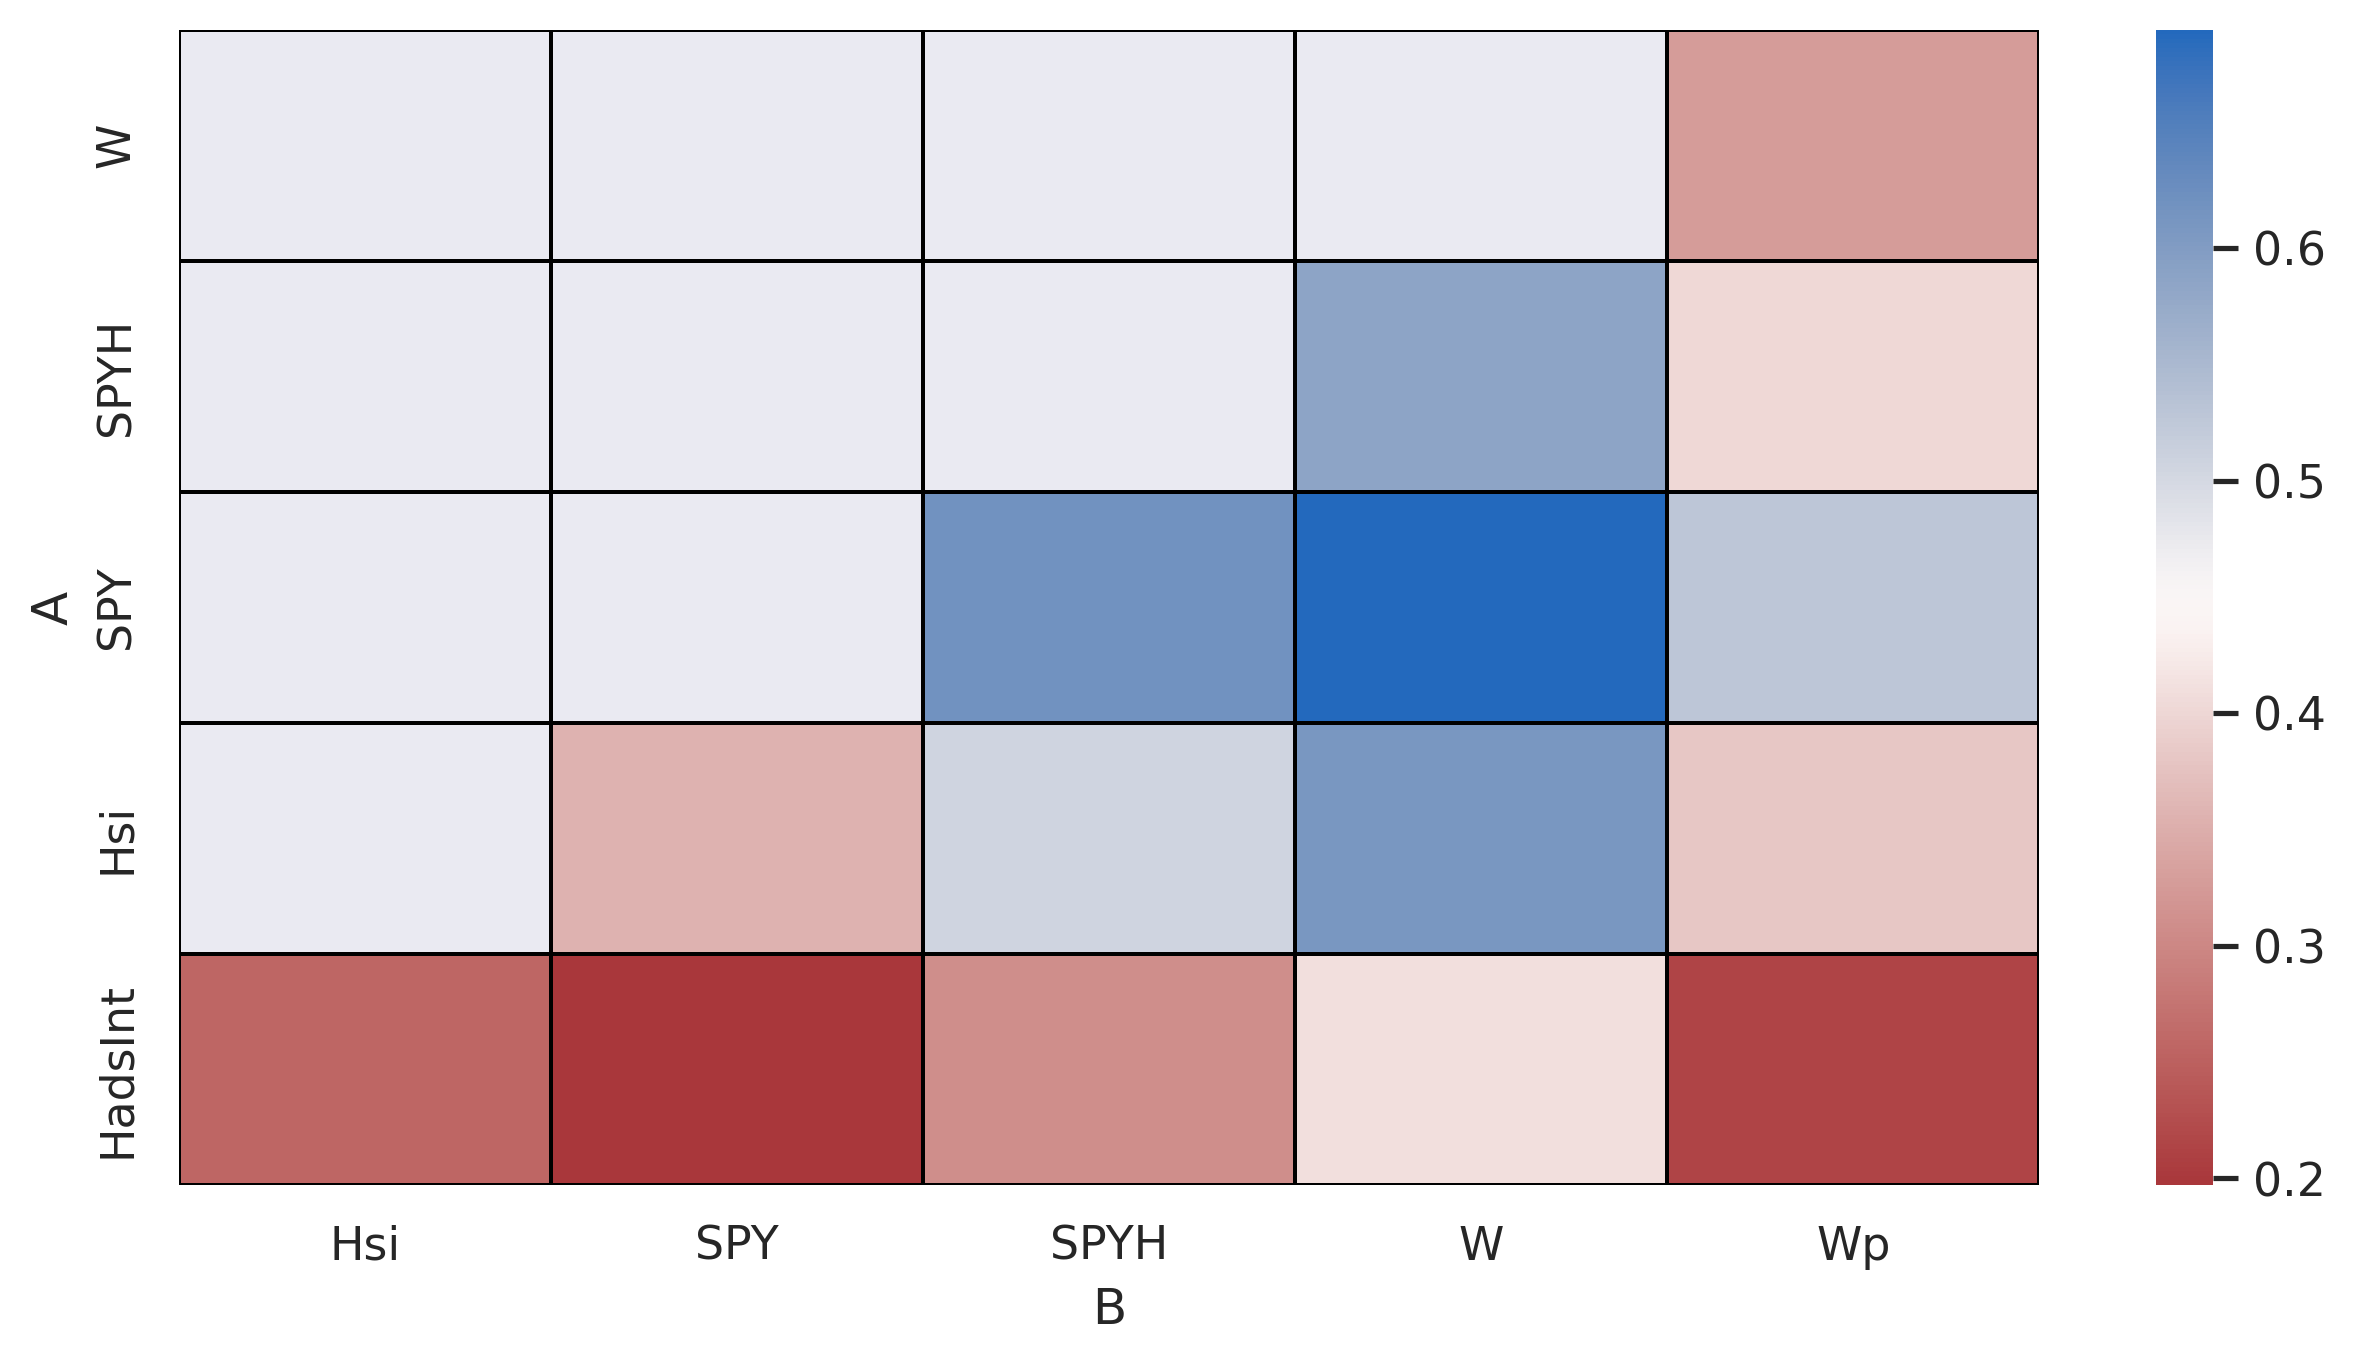

In [5]:
# p=sns.displot(data=df_equiv, x="APFDx", hue="CTT", kind="kde",palette='tab10', height=3, aspect=1.5)
# p.fig.set_dpi(200)

df_vda=vdadf(df_equiv.sort_values(['SUL name','CTT']),'APFDx','CTT')
df_vda.estimate = df_vda.estimate.astype(float)
df_vda.A = pd.Categorical(df_vda.A, ["W", "SPYH", "SPY", "Hsi", "HadsInt"])
df_vda.B = pd.Categorical(df_vda.B, ["Hsi", "SPY", "SPYH", "W", "Wp"])

df_vda['estimate_abs'] = np.abs(df_vda.estimate.astype(float)-0.5)

display(df_vda.sort_values(['estimate_abs'])[['A','B','estimate','magnitude']])
pvt=df_vda.pivot_table('estimate','A','B')
sns.heatmap(pvt,cmap='vlag_r', linewidth=.5, linecolor='black',mask=pvt.isnull())